In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('autos_limpio.csv', sep=',')

# Definir X como todas las columnas excepto 'Título', 'Versión', 'Color' y 'Precio'
X = df.drop(columns=['Título', 'Versión', 'Color', 'Precio'])

# Definir y como la columna 'Precio'
y = df['Precio']

## Analizamos correlaciones con respecto a Y

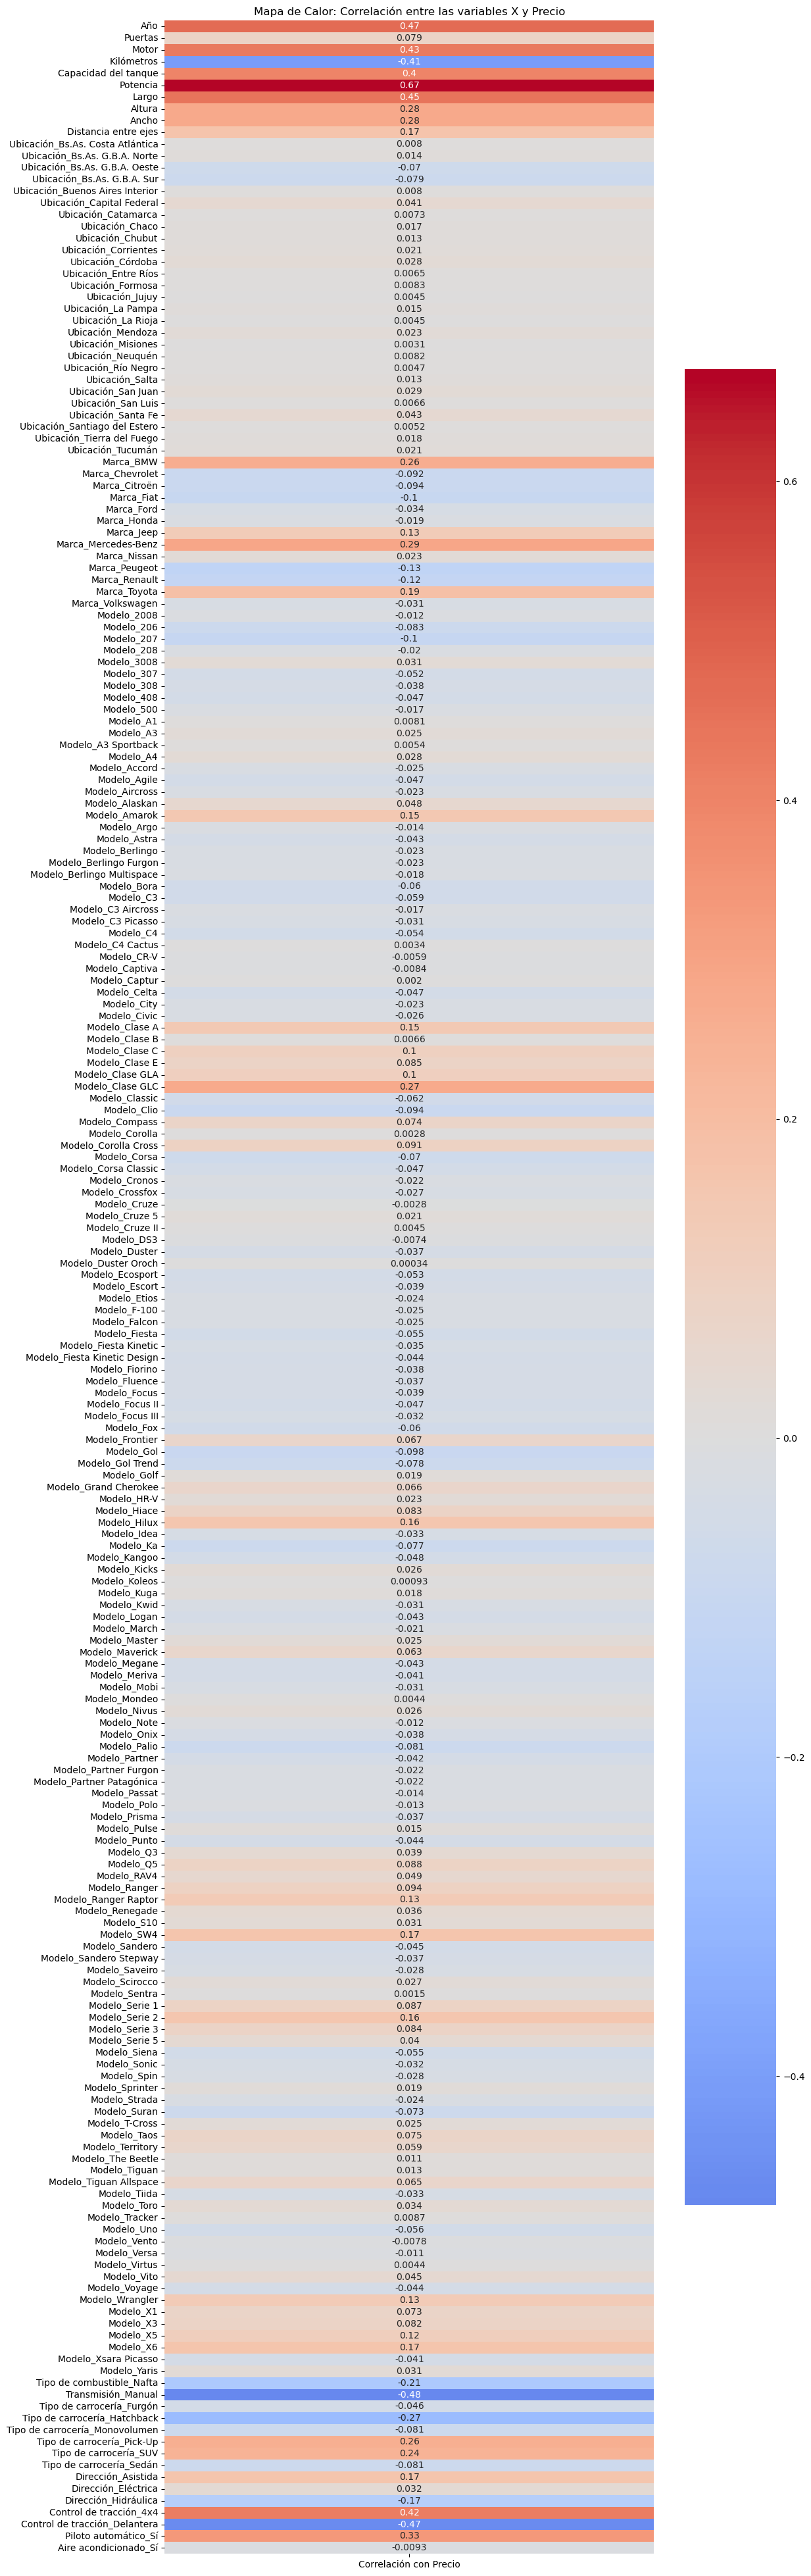

In [3]:
# Asegurarse de que y sea una serie, por si está en formato DataFrame
y = y.squeeze()  # Convierte y a una serie si es necesario

# Mapa de calor de las correlaciones entre X e y
plt.figure(figsize=(12, 50))

# Calculamos las correlaciones entre X y y
correlaciones_xy = X.corrwith(y).to_frame('Correlación con Precio')

# Generamos el heatmap
sns.heatmap(correlaciones_xy, annot=True, cmap='coolwarm', center=0)

# Título del gráfico
plt.title('Mapa de Calor: Correlación entre las variables X y Precio')

# Mostramos el gráfico
plt.show()

## Analizamos correlaciones entre las variables independientes

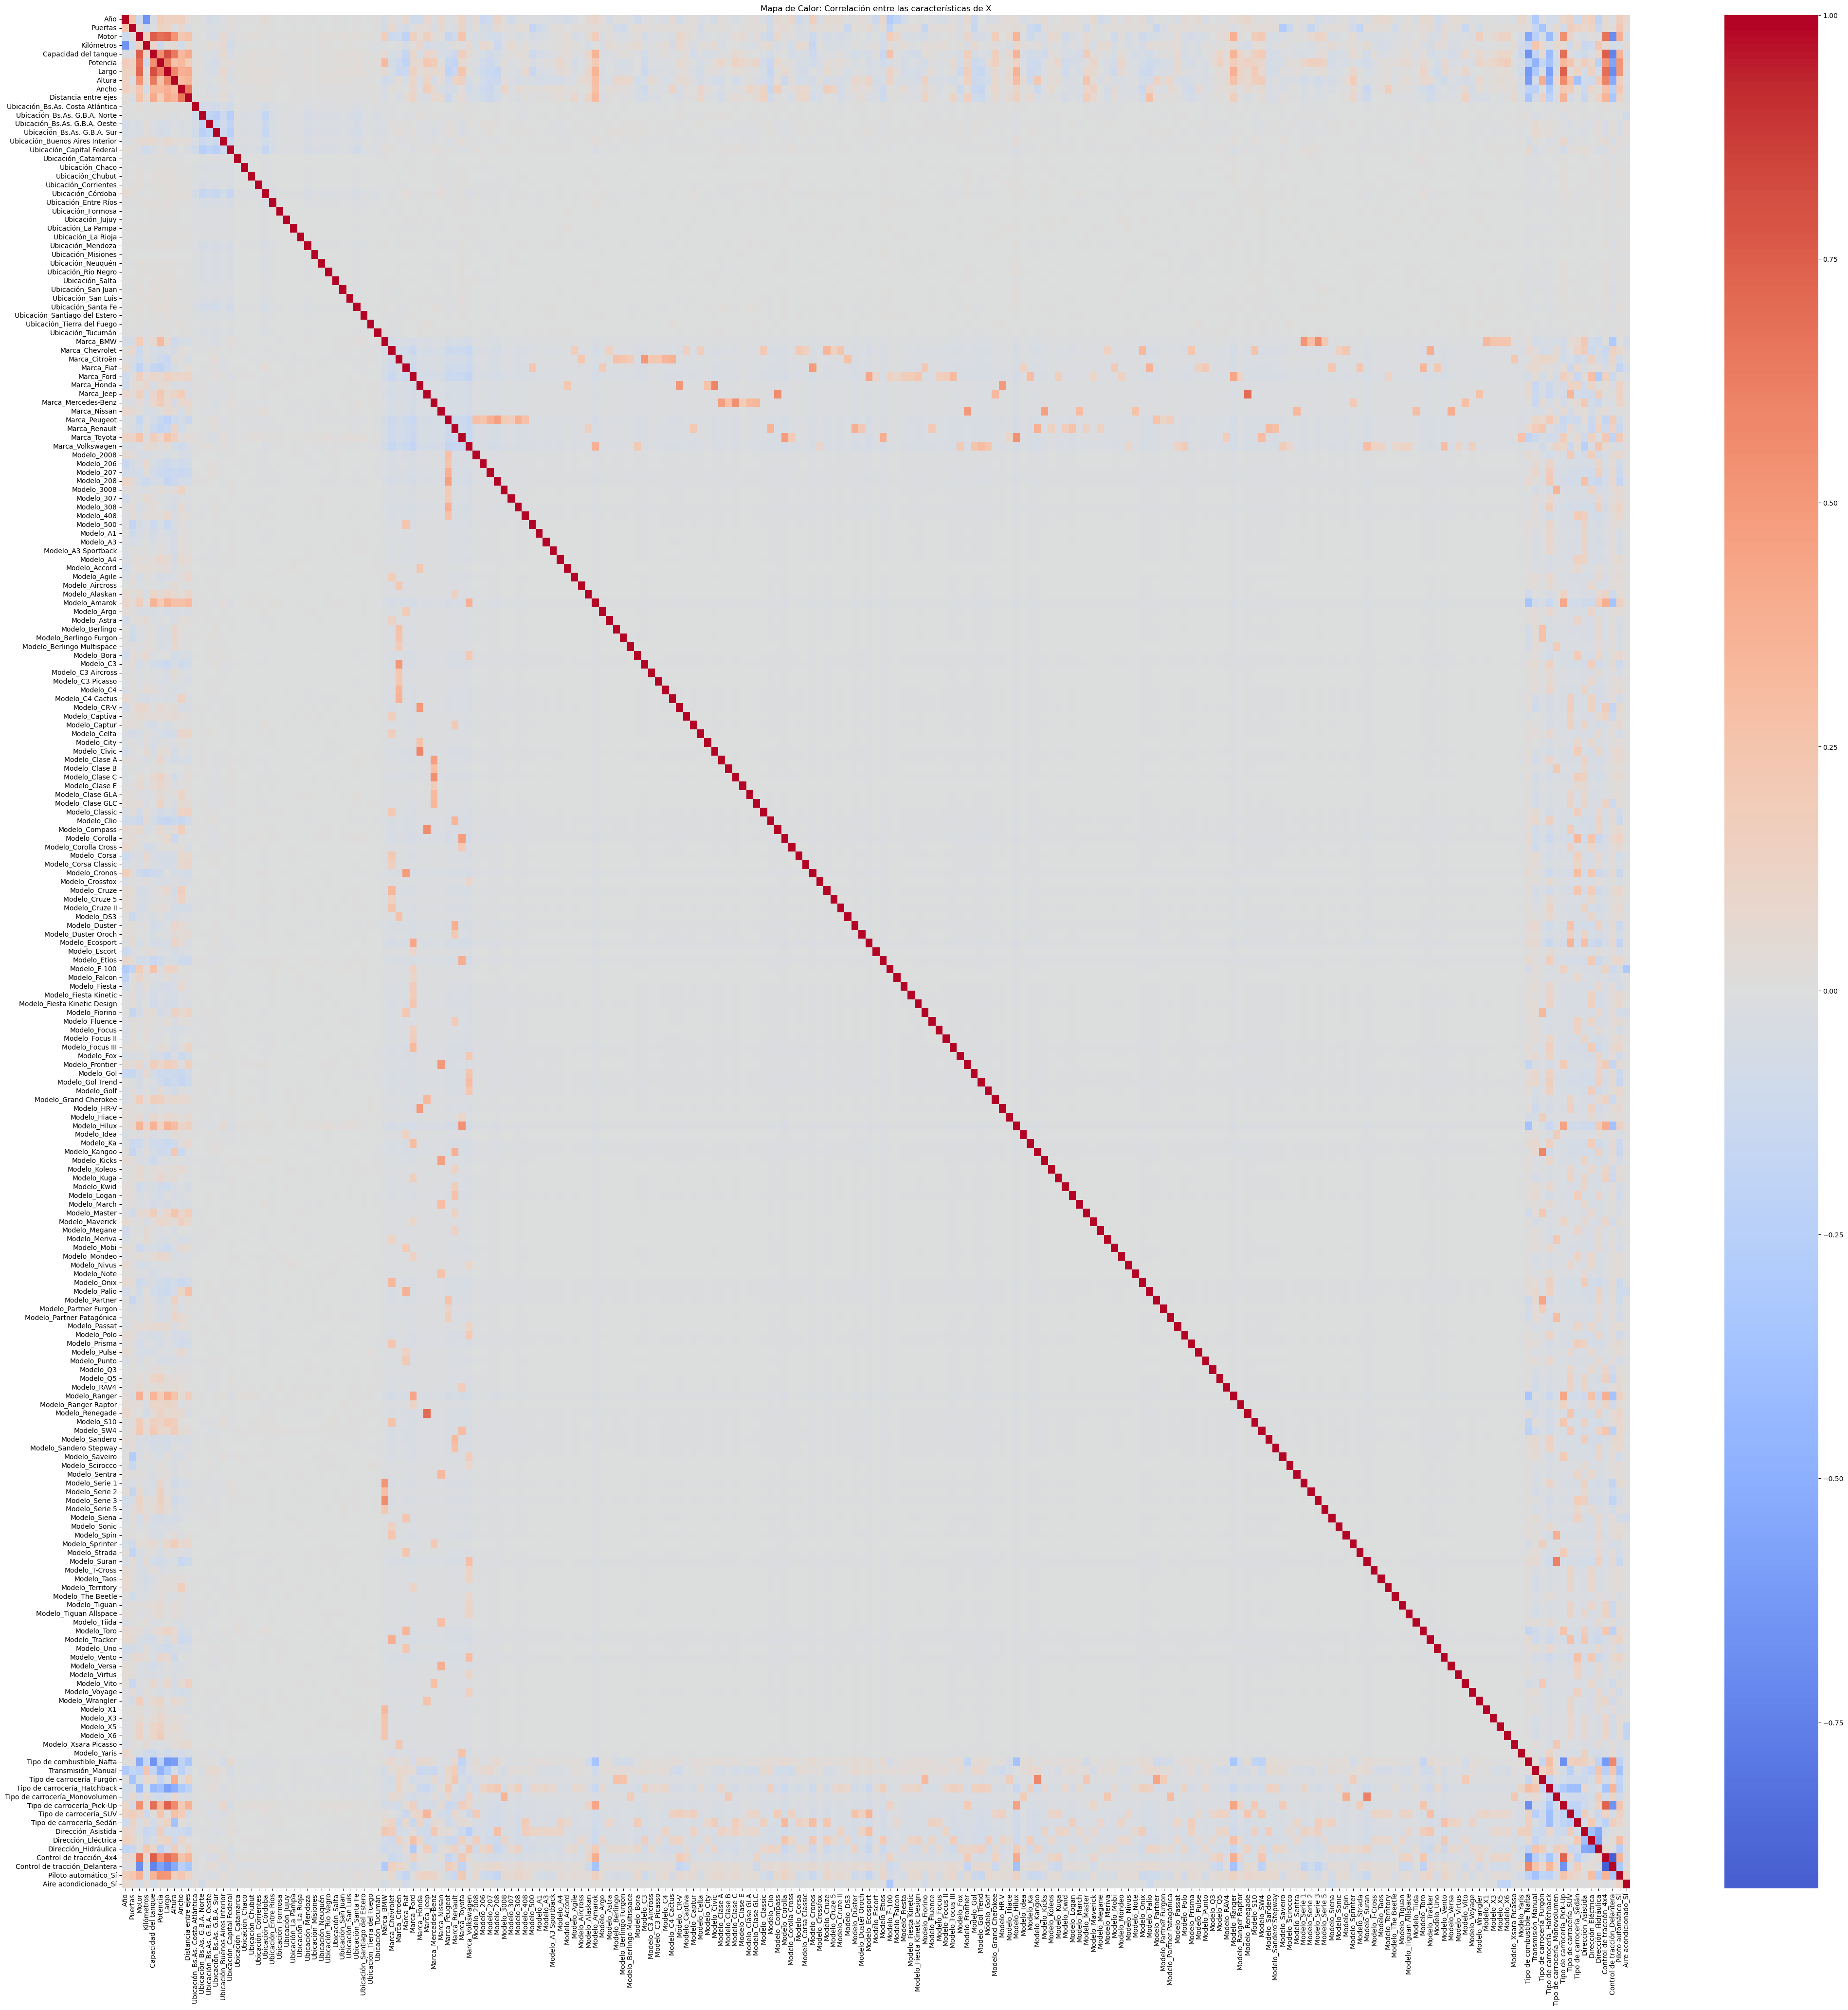

In [4]:
# Mapa de calor de las correlaciones entre las características de X
plt.figure(figsize=(50, 50))
correlaciones_XX = X.corr()
sns.heatmap(correlaciones_XX, annot=False, cmap='coolwarm', center=0)
plt.title('Mapa de Calor: Correlación entre las características de X')
plt.show()

In [5]:
# Filtrar las correlaciones mayores al umbral y menores al -umbral
umbral = 0.70
correlaciones_altas = correlaciones_XX[(correlaciones_XX > umbral) | (correlaciones_XX < -umbral)]

# Convertir la matriz de correlaciones a un DataFrame en formato largo (long format)
correlaciones_altas_unstack = correlaciones_altas.unstack().reset_index()

# Renombrar las columnas
correlaciones_altas_unstack.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtrar solo las correlaciones que no sean autocorrelaciones (excluir diagonal)
correlaciones_altas_unstack = correlaciones_altas_unstack[correlaciones_altas_unstack['Variable 1'] != correlaciones_altas_unstack['Variable 2']]

# Eliminar duplicados, ya que las correlaciones son simétricas
correlaciones_altas_unstack = correlaciones_altas_unstack.drop_duplicates(subset=['Correlación'])

# Filtrar las correlaciones no nulas
correlaciones_altas_unstack = correlaciones_altas_unstack.dropna()

# Mostrar las variables correlacionadas y su valor de correlación
print(correlaciones_altas_unstack)

                       Variable 1                     Variable 2  Correlación
434                         Motor           Capacidad del tanque     0.749640
436                         Motor                          Largo     0.722280
866          Capacidad del tanque                          Largo     0.812857
1071         Capacidad del tanque        Control de tracción_4x4     0.759905
1072         Capacidad del tanque  Control de tracción_Delantera    -0.733895
1495                        Largo     Tipo de carrocería_Pick-Up     0.739681
9405                   Marca_Jeep                Modelo_Renegade     0.703224
44286  Tipo de carrocería_Pick-Up        Control de tracción_4x4     0.730806
45577     Control de tracción_4x4  Control de tracción_Delantera    -0.920175


## Aplicamos XGBoost

In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Definir el número de folds (en este caso 10)
n_splits = 10

# Crear índices para dividir el conjunto de datos en K folds
n = len(X)
indices = np.arange(n)
np.random.shuffle(indices)  # Mezclar los índices para hacer la división aleatoria
folds = np.array_split(indices, n_splits)  # Dividir en 10 folds

# Listas para almacenar los resultados de cada fold
rmse_scores = []
r2_scores = []
r2_adj_scores = []
error_relativo_scores = []

# Listas para almacenar las predicciones de cada fold
predicciones_totales = np.zeros(n)  # Array para almacenar las predicciones de todos los folds

# Calcular el rango de la variable objetivo (Precio)
rango_y = y.max() - y.min()

# Hacer K-Fold Cross Validation manualmente
for i in range(n_splits):
    # Crear los conjuntos de entrenamiento y test para este fold
    test_index = folds[i]
    train_index = np.concatenate([folds[j] for j in range(n_splits) if j != i])
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Convertir a DMatrix para XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Parámetros del modelo
    params = {
        'objective': 'reg:squarederror',
        'max_depth': 6,
        'eta': 0.3
    }

    # Entrenar el modelo con los datos de entrenamiento del fold
    model = xgb.train(params, dtrain, num_boost_round=100)

    # Hacer predicciones sobre el conjunto de prueba
    y_pred = model.predict(dtest)

    # Evaluar el modelo en este fold
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    p = X_train.shape[1]
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    error_relativo = rmse / rango_y

    # Almacenar los resultados
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    r2_adj_scores.append(r2_adj)
    error_relativo_scores.append(error_relativo)
    
    print(f'Fold {i+1} -> RMSE: {rmse}, R²: {r2}, R² adj: {r2_adj}, Error Relativo: {error_relativo}')

    # Almacenar las predicciones del fold en el array predicciones_totales
    predicciones_totales[test_index] = y_pred

# Promediar los resultados de todos los folds
print(f'\nAverage RMSE: {np.mean(rmse_scores)}')
print(f'Average R²: {np.mean(r2_scores)}')
print(f'Average R² adj: {np.mean(r2_adj_scores)}')
print(f'Average Error Relativo: {np.mean(error_relativo_scores)}')

Fold 1 -> RMSE: 3063.3553409144424, R²: 0.9303225903917364, R² adj: 0.9280326724666712, Error Relativo: 0.016263167979698512
Fold 2 -> RMSE: 2714.8746305185396, R²: 0.9407613842190297, R² adj: 0.9388145327373867, Error Relativo: 0.014413104993155965
Fold 3 -> RMSE: 3906.8468640445326, R²: 0.8924671819526133, R² adj: 0.8889331624050456, Error Relativo: 0.02074121339183196
Fold 4 -> RMSE: 3655.2352904119434, R²: 0.9056973250719267, R² adj: 0.9025981084547552, Error Relativo: 0.019405422785704767
Fold 5 -> RMSE: 3771.3932854624186, R²: 0.895222830417063, R² adj: 0.891779374064215, Error Relativo: 0.020022098546580405
Fold 6 -> RMSE: 3465.4580228735776, R²: 0.9126669646559229, R² adj: 0.9097968022286871, Error Relativo: 0.018397906765776333
Fold 7 -> RMSE: 3525.185400032494, R²: 0.8949423215841774, R² adj: 0.8914891185786122, Error Relativo: 0.018714995793858952
Fold 8 -> RMSE: 3103.1160058414544, R²: 0.9313030397795082, R² adj: 0.9290449987387797, Error Relativo: 0.016474254941780907
Fold

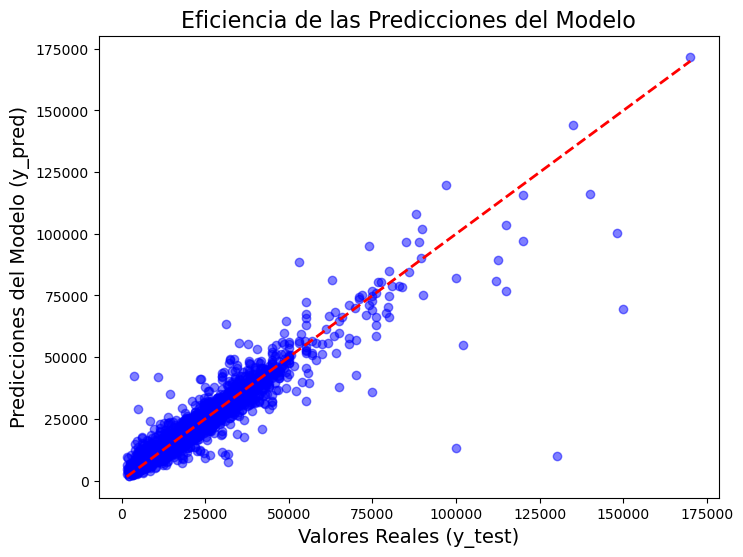

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones del modelo sobre el conjunto de test
y_pred = model.predict(dtest)

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

# Línea de identidad (donde y_test = y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)

# Títulos y etiquetas
plt.title('Eficiencia de las Predicciones del Modelo', fontsize=16)
plt.xlabel('Valores Reales (y_test)', fontsize=14)
plt.ylabel('Predicciones del Modelo (y_pred)', fontsize=14)

# Mostrar el gráfico
plt.show()

In [11]:
# Ahora agregamos las predicciones al DataFrame df
df['Precio Predicho'] = predicciones_totales

# Calculamos la diferencia entre el precio real y el precio predicho
df['Diferencia'] = df['Precio'] - df['Precio Predicho']

# Verificamos las primeras filas del DataFrame actualizado
df

,Título,Año,Versión,Color,Puertas,Motor,Kilómetros,Capacidad del tanque,Potencia,Largo,...,Dirección_Asistida,Dirección_Eléctrica,Dirección_Hidráulica,Control de tracción_4x4,Control de tracción_Delantera,Piloto automático_Sí,Aire acondicionado_Sí,Precio,Precio Predicho,Diferencia
0,Toyota Hilux Pick-Up 2.8 Cd Srv 177cv 4x4 At,2020,2.8 Cd Srv 177cv 4x4 At,Gris,5,2.8,55000,80.0,177.0,5260.0,...,0,0,1,1,0,1,1,33000.000000,35378.152344,-2378.152344
1,Renault Kangoo 1.6 Furgon Ph3 Confort 1plc,2017,1.6 Furgon Ph3 Confort 1plc,Rojo,3,1.6,134000,52.0,95.0,4010.0,...,0,0,1,0,1,0,1,11500.000000,11187.707031,312.292969
2,Volkswagen Fox 1.6 Comfortline 3 p,2011,1.6 Comfortline 3 p,Negro,3,1.6,140000,50.0,101.0,3823.0,...,0,0,1,0,1,0,1,7000.000000,7586.149414,-586.149414
3,Toyota Etios 1.5 XLS MT,2019,1.5 XLS MT,Negro,5,1.5,33000,45.0,103.0,4265.0,...,0,1,0,0,1,0,0,14238.461538,12890.927734,1347.533804
4,Volkswagen Amarok 2.0 Cd Tdi 180cv 4x2 Highlin...,2017,2.0 Cd Tdi 180cv 4x2 Highline Pack,NaN,5,2.0,189000,80.0,180.0,5254.0,...,0,0,1,1,0,1,1,22500.000000,22236.548828,263.451172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67571,Fiat 500 1.4 Cult 85cv,2013,1.4 Cult 85cv,Verde,3,1.4,106500,40.0,85.0,3546.0,...,1,0,0,0,1,0,1,9000.000000,10108.583008,-1108.583008
67572,Volkswagen Bora 2.0 Trendline 115cv,2013,2.0 Trendline 115cv,Negro,5,2.0,150000,55.0,116.0,4376.0,...,0,0,1,0,1,1,1,8900.000000,9642.517578,-742.517578
67573,Chevrolet S10 2.8 Cs 4x2 Ls Tdci 180cv,2012,2.8 Cs 4x2 Ls Tdci 180cv,Gris,5,2.8,200000,76.0,180.0,5367.0,...,1,0,0,0,1,1,1,9615.384615,13786.540039,-4171.155424
67574,Volkswagen Fox 1.6 Comfortline 3 p,2013,1.6 Comfortline 3 p,Gris,3,1.6,98000,50.0,101.0,3823.0,...,0,0,1,0,1,0,1,8000.000000,9080.089844,-1080.089844


In [12]:
# Guardar limpieza
# df.to_csv('prediccion_autos.csv', index=False)

## Creamos el archivo de Excel para visualizar los mejores autos para la compra

In [13]:
# Eliminar las columnas dummies creadas
dummies_columns = ['Ubicación', 'Marca','Modelo', 'Tipo de combustible', 'Transmisión', 'Tipo de carrocería', 
                   'Dirección', 'Control de tracción', 'Piloto automático', 'Aire acondicionado']

# Si el nombre de las columnas dummy es "Columna_Valor", puedes usar algo como:
df_cleaned = df.drop(columns=[col for col in df.columns if col in dummies_columns])

# Reconstruir las columnas categóricas originales a partir de las columnas dummy
# Vamos a realizar esto de manera manual, comparando las columnas dummy y asignando la categoría correspondiente
for col in dummies_columns:
    # Encuentra las columnas dummy relacionadas con la columna original
    cols_related = [c for c in df.columns if c.startswith(col)]
    
    # Asigna la categoría original basándote en las columnas dummy
    df_cleaned[col] = df[cols_related].idxmax(axis=1).apply(lambda x: x.split('_')[1])  # Usando idxmax para encontrar el valor máximo
    
    # Elimina las columnas dummy para dejar solo las categorías originales
    df_cleaned = df_cleaned.drop(columns=cols_related)

# Agregar la columna de "Precio Predicho" y "Diferencia" al DataFrame limpio
df_cleaned['Precio Predicho'] = df['Precio Predicho']
df_cleaned['Diferencia'] = df['Precio'] - df['Precio Predicho']

# Mover las columnas 'Precio', 'Precio Predicho' y 'Diferencia' al final
columnas = [col for col in df_cleaned.columns if col not in ['Precio', 'Precio Predicho', 'Diferencia']]  # Todas las columnas excepto las 3
df_cleaned = df_cleaned[columnas + ['Precio', 'Precio Predicho', 'Diferencia']]  # Reordenar con las 3 columnas al final

# Ahora tienes el DataFrame con las columnas originales y la predicción del precio.
pd.set_option('display.max_columns', None)
df_cleaned.head()

,Título,Año,Versión,Color,Puertas,Motor,Kilómetros,Capacidad del tanque,Potencia,Largo,Altura,Ancho,Distancia entre ejes,Ubicación,Marca,Modelo,Tipo de combustible,Transmisión,Tipo de carrocería,Dirección,Control de tracción,Piloto automático,Aire acondicionado,Precio,Precio Predicho,Diferencia
0,Toyota Hilux Pick-Up 2.8 Cd Srv 177cv 4x4 At,2020,2.8 Cd Srv 177cv 4x4 At,Gris,5,2.8,55000,80.0,177.0,5260.0,1850.0,1855.0,2860.0,Bs.As. G.B.A. Oeste,Toyota,Hilux,Nafta,Manual,Pick-Up,Hidráulica,4x4,Sí,Sí,33000.000000,35378.152344,-2378.152344
1,Renault Kangoo 1.6 Furgon Ph3 Confort 1plc,2017,1.6 Furgon Ph3 Confort 1plc,Rojo,3,1.6,134000,52.0,95.0,4010.0,1860.0,1672.0,2600.0,Bs.As. G.B.A. Norte,Renault,Kangoo,Nafta,Manual,Furgón,Hidráulica,Delantera,Sí,Sí,11500.000000,11187.707031,312.292969
2,Volkswagen Fox 1.6 Comfortline 3 p,2011,1.6 Comfortline 3 p,Negro,3,1.6,140000,50.0,101.0,3823.0,1544.0,1641.0,2465.0,Bs.As. G.B.A. Norte,Volkswagen,Fox,Nafta,Manual,Hatchback,Hidráulica,Delantera,Sí,Sí,7000.000000,7586.149414,-586.149414
3,Toyota Etios 1.5 XLS MT,2019,1.5 XLS MT,Negro,5,1.5,33000,45.0,103.0,4265.0,1510.0,1695.0,2460.0,Capital Federal,Toyota,Etios,Nafta,Manual,Hatchback,Eléctrica,Delantera,Sí,Sí,14238.461538,12890.927734,1347.533804
4,Volkswagen Amarok 2.0 Cd Tdi 180cv 4x2 Highlin...,2017,2.0 Cd Tdi 180cv 4x2 Highline Pack,NaN,5,2.0,189000,80.0,180.0,5254.0,1834.0,1944.0,3095.0,Bs.As. G.B.A. Norte,Volkswagen,Amarok,Nafta,Manual,Pick-Up,Hidráulica,4x4,Sí,Sí,22500.000000,22236.548828,263.451172


In [14]:
# Exportar el DataFrame a un archivo Excel
df_cleaned.to_excel("prediccion_autos.xlsx", index=False)